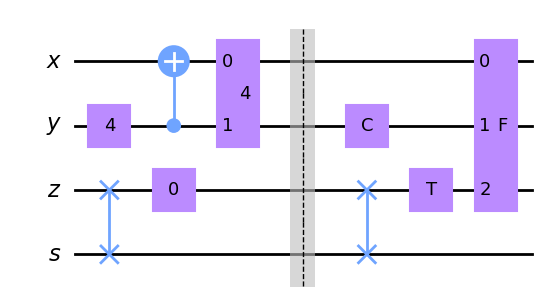

In [1]:
from machinerie import Circuit, draw404

draw404()

# Challenge 3 : Algorithme de Grover _cassé_ (2/2)

Notre ingénieur s'est trompé lorsqu'il a programmé l'algorithme, il a oublié des $H$... Comment faire pour récupérer le drapeau ? 

Soit un drapeau "00101011", le circuit complet s'écrit : 

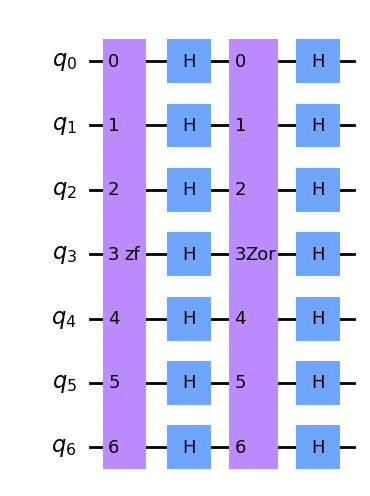

In [2]:
from machinerie import create_grover

flag = [0, 0, 1, 1, 0, 1, 1]
n = len(flag)

grover = create_grover(flag, range(n), range(n))
grover.draw_circuit()

In [5]:
full_circuit = Circuit(n)
full_circuit.h(range(n))
full_circuit.compose(grover, inplace=True)
full_circuit.compose(grover, inplace=True)
full_circuit.compose(grover, inplace=True)
full_circuit.compose(grover, inplace=True)
results = full_circuit.get_measure()
drapeau = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"""
Drapeau : {drapeau}
Probabilité : {results[drapeau]}
""")


Drapeau : 1101100
Probabilité : 0.52734375



À une inversion près, on retrouve notre drapeau en 4 coups, ... quand le circuit est bien implémenté. Ce n'est malheureusement pas le cas pour le circuit sur nos serveurs, il manque au moins 2 $H$ par colonne...

Par exemple : 

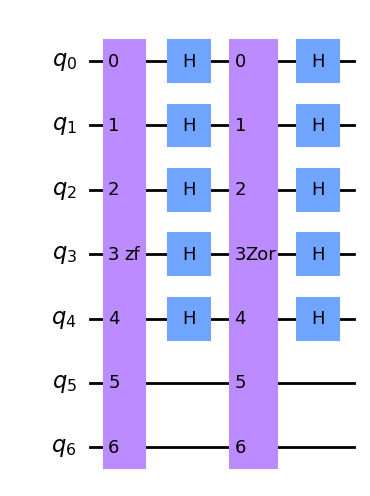

In [4]:
grover = create_grover(flag, range(n - 2), range(n - 2))
grover.draw_circuit()

Pour couronner le tout, il n'y a qu'une passe qui a été implémentée.

**Votre mission : récupérer le drapeau.**

Vous avez accès à 3 paramètres : 
- l'entrée
- les positions des $H$ entre $Z_f$ et $Z_\text{OR}$ - vous avez le droit d'en poser $\leq n-2$
- les positions des $H$ après $Z_\text{OR}$ - vous avez le droit d'en poser $\leq n-2$

à travers la fonction `test_flag_grover` (j'utilise exactement la même fonction côté API).


Pour éviter le brute force sur le CTFd directement, **vous devrez reproduire la procédure deux fois, pour récupérer deux drapeaux de 12 bits chacuns,** le drapeau final sera `404CTF{premier_flag+deuxième_flag}`, par exemple : `404CTF{0101010101010101010101010}`

Pour éviter l'explosion de votre ordinateur lors de l'appel à `get_flat_unitary`, vous utiliserez des angles pour m'envoyer votre entrée. À partir d'une liste de $n*3$ flottants, je construis n'importe quel état d'entré avec des portes $U$. Les angles sont ceux de la sphère de Bloch. Vous avez l'implémentation dans `Circuit` : `Circuit.from_angles()`.

Par exemple deux Hadamards : 

In [5]:
from math import pi

# theta_0, phi_0, lambda_0, theta_1, ...
angles = [0, 0, 0]  # [pi / 2, 0, pi, pi, 0, 0]
qc = Circuit.from_angles(angles)
qc.draw_qubits()

<IPython.core.display.Latex object>


En appelant l'API, vous obtiendrez une mesure. Pour éviter la surcharge, je mesure à chaque fois sur 1000 essais. ***Le brute force de l'API est évidemment toujours interdit, vous êtes sensé pouvoir trouver le drapeau avec moins de $30$ essais ($5$ si vous n'êtes pas trop malchanceux).*** 

## Solution

Même si l'algorithme de Grover ne pouvait pas être reproduit avec $n-2$ portes, il était possible de récupérer de l'information sur le drapeau en complexité linéaire. Par exemple, pour connaître les deux dernier bits, il était possible d'essayer la combinaison suivante : 

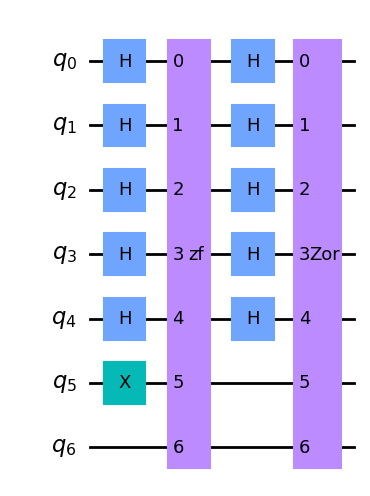

In [13]:
qc = Circuit(7)
qc.h([0, 1, 2, 3, 4])
qc.x(5)

grover = create_grover(flag, range(n - 2), [])

qc.compose(grover, inplace=True)
qc.draw_circuit()

Si le drapeau ne fini pas part 10, alors aucune des combinaison en entrée n'est égale au drapeau et $Z_f$ n'a aucun effet. Arrivé à la troisième couche, tous les $H$ sont annulés ($HH=I$), donc on se retrouve avec un état unique. $Z_\text{OR}$, n'a qu'un effect sur la polarisation, cela n'affectera pas la mesure. La sortie est donc 0000010 avec une probabilité de 1. 

Si le drapeau fini par 10, alors le drapeau fait parti des combinaisons en entrée et $Z_f$ aura un effet sur le bon drapeau. Sans dérouler les opérations, on peut voir que $H Z_f H$ n'est plus égal à l'identité, et qu'il y a donc des superpositions qui restent. La sortie sera donc une superposition de plusieurs possibilités. 

La résolution est alors la suivante : tester les qubits 2 par 2 (00, 01, 10, 11), si la mesure donne une superposition, alors c'est que les deux qubits sont bons. 

In [9]:
from math import pi

h = [pi / 2, 0, pi]
x = [pi, 0, 0]
zero = [0, 0, 0]

z = 10 * h

In [ ]:
import requests
from machinerie import q
import json
from math import pi

z = 10 * h + x + x + 0 * h
data = {
    "input_qubits": z,
    "hadamard_middle": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + [],
    "hadamard_end": [],
}

headers = {"Content-Type": "application/json", "Accept": "application/json"}
url = "https://causapscal-des-profondeurs.404ctf.fr/grover/2"
response = requests.post(url, json=data, headers=headers)

print(json.loads(response.content))

{'message': "{'000000001100': 0.0009765625, '000101110000': 0.001953125, '101010011111': 0.0009765625, '001000000100': 0.001953125, '010111011000': 0.0009765625, '010011110011': 0.0009765625, '011111000111': 0.0009765625, '111110000101': 0.0009765625, '101111000011': 0.0009765625, '110010111001': 0.0009765625, '111100111101': 0.001953125, '101001001100': 0.0009765625, '011100001010': 0.0009765625, '001001011100': 0.0009765625, '001100010010': 0.0009765625, '100011100101': 0.0009765625, '001100001010': 0.0009765625, '110000001111': 0.0009765625, '001011111010': 0.001953125, '000000010110': 0.0009765625, '101001010111': 0.0009765625, '110010101110': 0.001953125, '101100001101': 0.0009765625, '000111010001': 0.0009765625, '001000110011': 0.0009765625, '100011001110': 0.001953125, '110101111110': 0.0009765625, '100100011110': 0.001953125, '010001000110': 0.0009765625, '110101000110': 0.0009765625, '001010110000': 0.0009765625, '100100001111': 0.0009765625, '011110100010': 0.0009765625, '10